In [ ]:
import numpy
import scipy.io
import math
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import cm

mat = scipy.io.loadmat('dset.mat')
C = 10

In [ ]:
def task1_1(X, Y):
    N = len(X)
    D = len(X[0])
    
    x_bar = X.sum((0,))/N
    
    X_st = [numpy.asmatrix(x-x_bar) for x in X]
    S = sum([(x.transpose()@x).A for x in X_st])/N
    scipy.io.savemat('t1_S.mat', dict(S=S))
    
    sqrtd_vrns = [math.sqrt(S.item(i,i)) for i in range(D)]
    
    R = [
        S[i] / sqrtd_vrns / sqrtd_vrns[i]
        for i in range(D)
    ]
    
    scipy.io.savemat('t1_R.mat', dict(R=R))

In [ ]:
# task 1_2
task1_1(mat['X'], mat['Y_species'])
test_mat = scipy.io.loadmat('t1_R.mat')
R = test_mat['R']

cax = plt.matshow(R, interpolation='nearest')
plt.colorbar(cax)

D = len(R)
print([(i,j) for i in range (D) for j in range(D) if i!=j and (R.item(i,j)>0.2)])
plt.savefig('task1_2_covm.png')
plt.show()

In [ ]:
# task 1_2 (second graph)

def step_f(x):
    if x > 0.5:
        return 1
    elif x < -0.5:
        return -1
    else:
        return 0

R_selected = numpy.vectorize(step_f)(R)
fig = plt.figure()
cax = plt.matshow(R_selected, interpolation='nearest')
plt.colorbar(cax)
plt.savefig('task1_2_covm_stepped.png')

plt.show()

In [7]:

def listToColV(li):
    return numpy.asarray(li).reshape(-1,1)

def task1_3(Cov):
    D = len(Cov)
    EVals_orig, EVecs_orig = numpy.linalg.eig(Cov)

    sorted_evals = sorted(zip(EVals_orig, range(D)), reverse=True)
    EVals = [EVals_orig[i] for (_,i) in sorted_evals]

    def norm_EV(v):
        if v.item(0) > 0:
            return v
        else:
            return -v
    
    EVecs = [norm_EV(EVecs_orig[i]) for (_,i) in sorted_evals]

    scipy.io.savemat('t1_EVecs.mat', dict(EVecs=(numpy.asarray(EVecs).T)))
    scipy.io.savemat('t1_EVals.mat', dict(EVals=listToColV(EVals)))

    Cumvar = [sum(EVals[:(i+1)]) for i in range(D)]
    scipy.io.savemat('t1_Cumvar.mat', dict(Cumvar=listToColV(Cumvar)))

    def calcMinDims(variance_ratio):
        total_var = Cumvar[-1]
        indexed_Cumvar = zip(Cumvar, range(D))
        return min(
            [i+1 for (cv, i) in indexed_Cumvar \
                 if cv >= total_var * variance_ratio]
        )

    MinDims = [calcMinDims(perc/100) for perc in [70,80,90,95]]
    scipy.io.savemat('t1_MinDims.mat', dict(MinDims=listToColV(MinDims)))

In [ ]:
S = scipy.io.loadmat('t1_S.mat')['S']
task1_3(S)
testmat = scipy.io.loadmat('t1_MinDims.mat')['MinDims']
print(testmat)

In [ ]:
# 1.3b)
Cumvar_mat = scipy.io.loadmat('t1_Cumvar.mat')['Cumvar']
Cumvar = [x[0] for x in Cumvar_mat.tolist()]
plt.bar(range(1, len(Cumvar)+1), Cumvar)
#plt.bar()), Cumvar.tolist()) 
fig = plt.axes()
fig.set_ylabel('Variance')
fig.set_xlabel('Dimensions in PCA')
plt.savefig('task1_3b_cumvar_graph.png')
plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


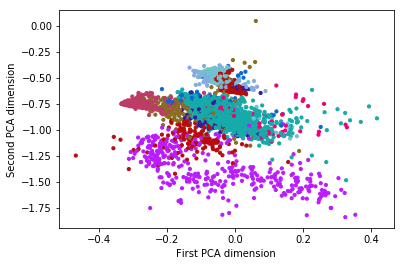

In [3]:
# 1.3c)
def task_1_3_c():
    X = mat['X']
    eigenvecs_cols = scipy.io.loadmat('t1_EVecs.mat')['EVecs']
    u = eigenvecs_cols[:,0].reshape(-1, 1)
    v = eigenvecs_cols[:,1].reshape(-1, 1)
    Y_n = numpy.matmul(X, u)
    Z_n = numpy.matmul(X, v)

    Y_species = mat['Y_species']
    class_colours = (numpy.random.rand(C,3)**1.5).tolist()
    colour_by_index = [class_colours[Y_species.item(i,0)-1] for i in range(len(Y_n))]
    plt.scatter([y[0] for y in Y_n], 
                [z[0] for z in Z_n],
                c=colour_by_index,
                s=10
    )
    fig = plt.axes()
    fig.set_xlabel('First PCA dimension')
    fig.set_ylabel('Second PCA dimension')
    plt.savefig('task1_3c_scatter_classes.png')

    plt.show()

task_1_3_c()

In [5]:
def calculatePMap(Y, Kfolds):
    class_freq = Counter(Y.T.tolist()[0])
    
    def Mc(class_num):
        return class_freq[class_num]//Kfolds
    
    current_class_partition = dict((i,1) for i in range(1,C+1))
    current_class_left = dict((i,Mc(i)) for i in range(1, C+1))
    
    PMap = []
    
    for i in range(len(Y)):
        class_num = Y.item(i,0) 
        
        # switch to next partition if no samples left
        if current_class_left[class_num] == 0 and \
                current_class_partition[class_num] != Kfolds:
            
            current_class_partition[class_num] += 1
            current_class_left[class_num] = Mc(class_num)
        
        PMap.append(current_class_partition[class_num])
        current_class_left[class_num] -= 1
    
    return PMap


def estimate_parameters(foldNum, X, class_samples):
    N = len(class_samples)
    mu_mle = sum([X[i] for i in class_samples]) / N
    X_st = [numpy.asmatrix(X[i]-mu_mle) for i in class_samples]
    # different order in matrix multiplication 
    #  because x-s are row and not column vectors initially
    Eps_mle = sum([(x.transpose()@x).A for x in X_st]) / N

    return mu_mle, Eps_mle


def task1_mgc_cv(X, Y, CovKind, epsilon, Kfolds):
    # TODO!: ask if this really should be the file name, 
    #  as we need to submit it for each CovKind
    PMap = calculatePMap(Y, Kfolds)
    scipy.io.savemat(f't1_mgc_{Kfolds}cv_PMap.mat', dict(PMap=listToColV(PMap)))  
    
  
    
    freq_confusion_matrices = dict()
    
    for p in range(1, Kfolds+1):
        training_samples = [i for i in range(len(PMap)) if PMap[i] != p]
        test_samples = [i for i in range(len(PMap)) if PMap[i] == p]
        mu_hats, Eps_regs = [], []
        
        for c in range(1, C+1):
            class_samples = [i for i in training_samples if Y.item(i,0) == c]
                        
            mu_hat, Eps_hat = estimate_parameters(p, X, class_samples)
            mu_hats.append(mu_hat)
                        
            if CovKind == 2:
            # zero everything except the diagonal
            #  (Numpy has a bit of a weird way of doing this)
                Eps_hat = numpy.diag(numpy.diag(Eps_hat))
                
             # regularising
            Eps_reg = Eps_hat + numpy.identity(len(Eps_hat))*epsilon
            Eps_regs.append(Eps_reg)
        
        if CovKind == 3:
            Eps = sum(Eps_regs)/C
            Eps_regs = [Eps for _ in Eps_regs]

        
        # save the MLEs for all classes
        scipy.io.savemat(f't1_mgc_{Kfolds}cv{p}_Ms.mat', dict(Ms=mu_hats))
        scipy.io.savemat(f't1_mgc_{Kfolds}cv{p}_ck{CovKind}_Covs.mat', 
                         dict(Covs=Eps_regs))
        
        # classification of test samples
        class_log_posteriors = [[] for i in range(len(X))]
        class_cnts = Counter([Y.item(i,0) for i in test_samples])
        for c in range(1, C+1):
            mu, Eps = mu_hats[c-1], Eps_regs[c-1]
            
            log_prior = math.log(class_cnts[c]/len(training_samples))
            log_det = math.log(numpy.linalg.det(Eps))
            
            for i in test_samples:
                x_r = X[i]-mu # row vector
                x = x_r.reshape(-1, 1) # column vector
                first_term = x_r @ numpy.linalg.inv(Eps) @ x
                log_posterior = (-1/2) * first_term - (1/2) * log_det + log_prior
                class_log_posteriors[i].append((log_posterior, c))
                
        
        classifications = [max(posteriors, default=([],[]))[1]
                               for posteriors in class_log_posteriors]
        
        confusion_matrix = numpy.ndarray((C,C))
        confusion_matrix.fill(0.0)
        
        for i in test_samples:
            class_real = Y.item(i, 0)
            class_predicted = classifications[i]
            coords = (class_real-1, class_predicted-1)
            confusion_matrix.itemset(coords, confusion_matrix.item(coords)+1)
        
        freq_confusion_matrices[p] = confusion_matrix/len(test_samples)
        scipy.io.savemat(f't1_mgc_{Kfolds}cv{p}_ck{CovKind}_CM.mat', 
                         dict(CM=confusion_matrix))
    
    final_confusion_matrix = sum([cm for cm in freq_confusion_matrices.values()])/Kfolds
    scipy.io.savemat(f't1_mgc_{Kfolds}cv{Kfolds+1}_ck{CovKind}_CM.mat', 
                     dict(CM=final_confusion_matrix))    

In [9]:
#1.4b
for CovKind in [1,2,3]:
    task1_mgc_cv(mat['X'], mat['Y_species'], CovKind, 0.01, 5)
    score = sum(numpy.diag(scipy.io.loadmat(f't1_mgc_5cv6_ck{CovKind}_CM.mat')['CM']))
    print(f'for CovKind={CovKind}, accuracy is {score}')

for CovKind=1, accuracy is 0.9010093896713613
for CovKind=2, accuracy is 0.8302816901408451
for CovKind=3, accuracy is 0.8827062374245472


In [10]:
#1.4c

epsilons = []
scores = []
for epsilon in [0.8**i for i in range(1, 50)]:
    task1_mgc_cv(mat['X'], mat['Y_species'], 1, epsilon, 5)
    final_confusion_matrix = scipy.io.loadmat(f't1_mgc_5cv6_ck1_CM.mat')['CM']
    score = sum(numpy.diag(final_confusion_matrix))
    print(score)
    epsilons.append(epsilon)
    scores.append(score)

0.499533869886
0.50047954393
0.503323272971
0.512112676056
0.527541918176
0.537994634474
0.541321260899
0.5448759222
0.551287726358
0.645556673374
0.701807511737
0.733601609658
0.752357478203
0.773484238766
0.794154929577
0.822890677398
0.844265593561
0.864668008048
0.882964453387
0.895073775989
0.905036887995
0.912877263581
0.921180415828
0.924034205231
0.927122736419
0.931160295104
0.934714956405
0.941847753186
0.949439973172
0.956083165661
0.962498323273
0.965345405768
0.968192488263
0.971274312542
0.974590878605
0.978152246814
0.984329309188
0.98932260228
0.990513078471
0.991462105969
0.992414486922
0.992414486922
0.991938296445
0.991224010731
0.990985915493
0.991931589537
0.991462105969
0.991462105969
0.991462105969


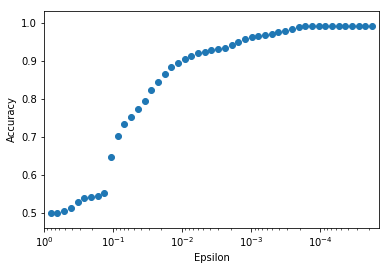

In [12]:
fig, ax = plt.subplots()
ax.scatter(epsilons, scores)
plt.xscale('log')
ax.set_xlim(1, 0.8**50)
ax.set_xlabel('Epsilon')
ax.set_ylabel('Accuracy')
plt.savefig('task1_4c_epsilons_accuracy.png')
plt.show()